In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/0825dataset(sleep).csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry", "EMA_T_Diff",'bored','How_stressed','How_tired',
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
    
]


# Remove rows with missing values
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()

# 기본 데이터셋 준비 (기존과 동일)
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# GroupKFold 설정
gkf = GroupKFold(n_splits=5)

# 결과 저장용 리스트
metrics = []
feature_importance_list = []

threshold = 0.3  # 고정 threshold

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 모델 학습
    model = RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=50,
        min_samples_leaf=50,
        max_features=None,
        max_depth=50,
        criterion='entropy',
        class_weight=None,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # Feature importance 저장
    feature_importance_list.append(model.feature_importances_)

# 평균 결과 출력
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# Feature importance 평균
feature_importance_avg = np.mean(feature_importance_list, axis=0)
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance_avg
}).sort_values("Importance", ascending=False)

print("\n🔍 평균 Feature Importance (Top 15):")
print(importances.head(15))

/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_14720/111915411.py:17: DtypeWarning: Columns (101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="utf-8")



📂 Fold 1

📂 Fold 2

📂 Fold 3

📂 Fold 4

📂 Fold 5

📊 GroupKFold (5-fold) 평균 성능:

Accuracy     0.6871
Precision    0.1395
Recall       0.4236
F1           0.2097
ROC AUC      0.6425
PR AUC       0.1449
dtype: float64

🔍 평균 Feature Importance (Top 15):
              Feature  Importance
52          Intensity    0.202159
18  mean_intensity_1h    0.128669
13             hungry    0.104310
12           Time_24h    0.051596
48       Z_Previous_4    0.033941
45     2_2.5h_pre_std    0.030458
39     1_1.5h_pre_std    0.025804
42     1.5_2h_pre_std    0.024588
16       How_stressed    0.022613
17          How_tired    0.022112
30          TimeInBed    0.020305
14         EMA_T_Diff    0.016512
32         Sleep_Diff    0.016334
2        15m_G_Diff_7    0.015241
50        Z_Intensity    0.014588


In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score

# ===== 0) 설정 =====
FEATURES = X_columns                # 이미 정의됨
LABEL_COL = "GE_1h"                 # 현재 라벨 이름
GROUP_COL = "StudyID"
TS_COL = "Timestamp"                # df에 존재하는 타임스탬프 컬럼명

# ===== 1) df_model 정리: y_true 생성 =====
df_model_oof = df_model.copy()
if "y_true" not in df_model_oof.columns:
    df_model_oof["y_true"] = df_model_oof[LABEL_COL].astype(int)

# ===== 2) 메타정보(ts/date/hour_float) 복구 =====
ts_series = pd.to_datetime(df.loc[df_model_oof.index, TS_COL], errors="coerce")
meta = pd.DataFrame({
    "StudyID": df_model_oof[GROUP_COL].values,
    "ts": ts_series.values,
    "date": ts_series.dt.date.values,
    "hour_float": (ts_series.dt.hour + ts_series.dt.minute/60.0).values,
    "y_true": df_model_oof["y_true"].values
}).dropna(subset=["ts"])

# ===== 3) OOF 확률 계산 (GroupKFold + SMOTE 각 fold마다 적용) =====
X_all = df_model_oof[FEATURES].to_numpy()
y_all = df_model_oof["y_true"].to_numpy()
groups = df_model_oof[GROUP_COL].to_numpy()

oof_prob = np.zeros(len(df_model_oof), dtype=float)
oof_true = np.zeros(len(df_model_oof), dtype=int)

gkf = GroupKFold(n_splits=5)

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_all, y_all, groups)):
    X_tr, y_tr = X_all[tr_idx], y_all[tr_idx]
    X_va, y_va = X_all[va_idx], y_all[va_idx]

    # SMOTE (fold 내부에서만)
    cnt1 = np.bincount(y_tr)[1] if 1 in np.unique(y_tr) else 0
    if cnt1 > 1:
        k_neighbors = min(5, cnt1 - 1)
        sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_tr, y_tr = sm.fit_resample(X_tr, y_tr)

    model_fold = RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=50,
        min_samples_leaf=50,
        max_features=None,
        max_depth=50,
        criterion='entropy',
        class_weight=None,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model_fold.fit(X_tr, y_tr)
    prob_va = model_fold.predict_proba(X_va)[:, 1]

    oof_prob[va_idx] = prob_va
    oof_true[va_idx] = y_va

    print(f"Fold {fold+1} ROC-AUC: {roc_auc_score(y_va, prob_va):.3f}")

print(f"OOF ROC-AUC (all): {roc_auc_score(oof_true, oof_prob):.3f}")

# ===== 4) pred_df_oof 생성 (정책 함수가 요구하는 칼럼들 포함) =====
pred_df_oof = meta.copy()
pred_df_oof["y_prob"] = oof_prob

need_cols = {"StudyID","ts","date","hour_float","y_true","y_prob"}
missing = need_cols - set(pred_df_oof.columns)
assert not missing, f"pred_df_oof missing columns: {missing}"

# ===== 5) 정책 적용 =====
def summarize_alerts_table(alerts_df: pd.DataFrame):
    if alerts_df is None or alerts_df.empty:
        print("No alerts after policy.")
        empty = pd.DataFrame(columns=["StudyID","UniqueDays","TotalAlerts","Alerts_per_day_mean","Alerts_per_day_median"])
        return empty, np.nan

    per_pid_day = alerts_df.groupby(["StudyID","date"]).size().reset_index(name="alerts")
    per_pid = (per_pid_day.groupby("StudyID")["alerts"]
               .agg(UniqueDays="count", TotalAlerts="sum",
                    Alerts_per_day_mean="mean", Alerts_per_day_median="median")
               .reset_index())

    success_rate = float(alerts_df["success"].mean())

    print("\n=== Policy-level alert summary (TABLE) ===")
    print(f"Total alerts: {len(alerts_df)}")
    print(f"Overall success rate: {success_rate:.3f}")
    print(f"Median alerts/day across participants: {per_pid['Alerts_per_day_median'].median():.2f}")
    print(f"Mean alerts/day across participants: {per_pid['Alerts_per_day_mean'].mean():.2f}")

    return per_pid, success_rate

def generate_alerts_with_policy_fast(
    pdf: pd.DataFrame,
    threshold: float = 0.3,
    min_hour: float = 8.0,
    max_hour: float = 22.0,
    require_two_hits: bool = True,
    two_hit_window_min: int = 30,
    cooldown_min: int = 120,
    per_day_cap: int = 4,
    high_conf_single_hit_prob: float = None
):
    need_cols = ["StudyID","ts","date","y_true","y_prob","hour_float"]
    if not set(need_cols).issubset(pdf.columns):
        raise KeyError(f"pred_df_oof missing {list(set(need_cols)-set(pdf.columns))}")

    d = pdf.loc[(pdf["hour_float"] >= min_hour) & (pdf["hour_float"] <= max_hour), need_cols].copy()
    d["is_pos"] = (d["y_prob"] >= threshold).astype(np.uint8)
    d = d[d["is_pos"] == 1]
    if d.empty:
        return pd.DataFrame(columns=["StudyID","ts","date","y_true_at_alert","y_prob_at_alert","success"])

    alerts = []
    for (pid, day), g in d.sort_values(["StudyID","date","ts"]).groupby(["StudyID","date"]):
        times = g["ts"].to_numpy()
        probs = g["y_prob"].to_numpy(dtype=float)
        yts   = g["y_true"].to_numpy(dtype=int)

        if require_two_hits:
            win = np.timedelta64(two_hit_window_min, "m")
            j_right = np.searchsorted(times, times + win, side="right") - 1
            has_pair = (j_right > np.arange(len(times)))
            has_pair &= (times[j_right] - times) <= win

            if high_conf_single_hit_prob is not None:
                high_conf = probs >= float(high_conf_single_hit_prob)
                cand_mask = has_pair | high_conf
            else:
                cand_mask = has_pair

            if not np.any(cand_mask):
                continue
            cand_idx = np.nonzero(cand_mask)[0]
        else:
            cand_idx = np.arange(len(times))

        selected = []
        if len(cand_idx) > 0:
            cooldown = np.timedelta64(cooldown_min, "m")
            last_alert_time = times[0] - cooldown - np.timedelta64(1, "m")
            # 확률 높은 순으로 선택 (time 우선이면 probs 대신 times로 정렬)
            for i in cand_idx[np.argsort(-probs[cand_idx])]:
                if times[i] - last_alert_time < cooldown:
                    continue
                selected.append(i)
                last_alert_time = times[i]
                if len(selected) >= per_day_cap:
                    break

        if not selected:
            continue
        for i in selected:
            alerts.append({
                "StudyID": pid, "ts": times[i], "date": day,
                "y_true_at_alert": int(yts[i]),
                "y_prob_at_alert": float(probs[i])
            })

    if not alerts:
        return pd.DataFrame(columns=["StudyID","ts","date","y_true_at_alert","y_prob_at_alert","success"])

    alerts_df = pd.DataFrame(alerts)
    alerts_df["success"] = alerts_df["y_true_at_alert"].astype(int)
    return alerts_df

# 너의 S1 정책 그대로
S1 = dict(
    threshold=0.30,
    min_hour=8.0, max_hour=22.0,
    require_two_hits=True,
    two_hit_window_min=45,
    cooldown_min=90,
    per_day_cap=5,
    high_conf_single_hit_prob=0.60
)

alerts_S1 = generate_alerts_with_policy_fast(pred_df_oof, **S1)
per_pid_S1, sr_S1 = summarize_alerts_table(alerts_S1)

tp = int(alerts_S1["success"].sum())
total = len(alerts_S1)
print(f"Event-level: TP={tp}, FP={total - tp}, Total={total} (SR={tp/total:.3f})")


Fold 1 ROC-AUC: 0.656
Fold 2 ROC-AUC: 0.631
Fold 3 ROC-AUC: 0.624
Fold 4 ROC-AUC: 0.638
Fold 5 ROC-AUC: 0.667
OOF ROC-AUC (all): 0.643

=== Policy-level alert summary (TABLE) ===
Total alerts: 692
Overall success rate: 0.140
Median alerts/day across participants: 2.00
Mean alerts/day across participants: 2.09
Event-level: TP=97, FP=595, Total=692 (SR=0.140)


In [45]:
# ===== 6) 120분 성공 재마킹 =====
def mark_success_window(alerts_df: pd.DataFrame, full_df: pd.DataFrame, window_min: int = 120):
    alerts = alerts_df.copy()
    alerts["success_120m"] = 0
    
    # full_df에서 필요한 칼럼만
    full = full_df[["StudyID", "ts", "y_true"]].copy()
    
    for i, row in alerts.iterrows():
        sid = row["StudyID"]
        t0 = row["ts"]
        t1 = t0 + pd.Timedelta(minutes=window_min)
        
        # 같은 참가자에서 alert 이후 window_min 내에 GE 발생 있는지 확인
        mask = (full["StudyID"] == sid) & (full["ts"] > t0) & (full["ts"] <= t1)
        if (full.loc[mask, "y_true"] == 1).any():
            alerts.at[i, "success_120m"] = 1
    
    return alerts

# 실행
alerts_S1_120 = mark_success_window(alerts_S1, pred_df_oof, window_min=120)

# 결과 요약
tp = int(alerts_S1_120["success_120m"].sum())
total = len(alerts_S1_120)
fp = total - tp
sr = tp / total if total > 0 else float("nan")

print(f"\n=== Policy alerts (120m window) ===")
print(f"TP={tp}, FP={fp}, Total={total}, SR={sr:.3f}")



=== Policy alerts (120m window) ===
TP=222, FP=470, Total=692, SR=0.321


# Continuous Perfomance Metrix (Trend, mean)

In [56]:
# 원본 df의 Timestamp를 datetime으로 변환
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# pred_df_oof_full 생성 (Glucose merge)
df_glucose = df[["StudyID", "Timestamp", "Glucose"]].copy()
df_glucose.rename(columns={"Timestamp": "ts"}, inplace=True)

pred_df_oof_full = pred_df_oof.merge(df_glucose, on=["StudyID", "ts"], how="left")

print(pred_df_oof_full.dtypes)
print(pred_df_oof_full.head())



StudyID                int64
ts            datetime64[ns]
date                  object
hour_float           float64
y_true                 int64
y_prob               float64
Glucose                int64
dtype: object
   StudyID                  ts        date  hour_float  y_true    y_prob  \
0        1 2022-10-13 15:12:00  2022-10-13       15.20       1  0.325259   
1        1 2022-10-13 15:27:00  2022-10-13       15.45       1  0.437040   
2        1 2022-10-13 15:42:00  2022-10-13       15.70       1  0.449190   
3        1 2022-10-13 15:57:00  2022-10-13       15.95       1  0.290762   
4        1 2022-10-13 16:12:00  2022-10-13       16.20       1  0.416005   

   Glucose  
0       98  
1       95  
2       90  
3      100  
4      112  


# Δglucose

In [61]:
def add_delta_glucose(alerts_df: pd.DataFrame, full_df: pd.DataFrame, window_min: int = 120):
    alerts = alerts_df.copy()
    alerts["delta_glucose"] = np.nan

    for i, row in alerts.iterrows():
        sid = row["StudyID"]
        t0 = row["ts"]
        t1 = t0 + pd.Timedelta(minutes=window_min)

        # Alert 시점 혈당
        g0_series = full_df.loc[(full_df["StudyID"] == sid) & (full_df["ts"] == t0), "Glucose"]
        if g0_series.empty:
            continue
        g0 = g0_series.values[0]

        # 120분 내 최대 혈당
        mask = (full_df["StudyID"] == sid) & (full_df["ts"] > t0) & (full_df["ts"] <= t1)
        g_max = full_df.loc[mask, "Glucose"].max()

        if pd.isna(g_max):
            continue

        alerts.at[i, "delta_glucose"] = g_max - g0

    return alerts


In [65]:
alerts_S1_120 = add_delta_glucose(alerts_S1_120, pred_df_oof_full, window_min=120)

print(alerts_S1_120[["StudyID","ts","success_120m","delta_glucose"]].head())

# Δglucose 요약
print("\n=== Δglucose summary ===")
print("Total mean Δglucose:", alerts_S1_120["delta_glucose"].mean())
print("TP Δglucose:", alerts_S1_120.loc[alerts_S1_120["success_120m"]==1, "delta_glucose"].mean())
print("FP Δglucose:", alerts_S1_120.loc[alerts_S1_120["success_120m"]==0, "delta_glucose"].mean())


   StudyID                  ts  success_120m  delta_glucose
0        1 2022-10-13 21:12:00             0           -1.0
1        1 2022-10-14 11:42:00             0            9.0
2        1 2022-10-14 15:57:00             1           15.0
3        1 2022-10-14 20:42:00             0            0.0
4        1 2022-10-15 17:27:00             1           29.0

=== Δglucose summary ===
Total mean Δglucose: 12.745296671490593
TP Δglucose: 23.414414414414413
FP Δglucose: 7.6950959488272925


In [67]:
def evaluate_delta_success(alerts_df, delta_thresholds=[0, 5, 10]):
    results = {}
    for thr in delta_thresholds:
        alerts_thr = alerts_df.copy()
        alerts_thr["success_delta"] = (alerts_thr["delta_glucose"] >= thr).astype(int)
        
        tp = int(alerts_thr["success_delta"].sum())
        total = len(alerts_thr)
        sr = tp / total if total > 0 else float("nan")
        
        results[thr] = dict(TP=tp, Total=total, SR=sr)
    
    return results

# 실행
delta_results = evaluate_delta_success(alerts_S1_120, delta_thresholds=[0, 5, 10])

for thr, res in delta_results.items():
    print(f"Δglucose ≥ {thr}: TP={res['TP']}, Total={res['Total']}, SR={res['SR']:.3f}")


Δglucose ≥ 0: TP=544, Total=692, SR=0.786
Δglucose ≥ 5: TP=425, Total=692, SR=0.614
Δglucose ≥ 10: TP=327, Total=692, SR=0.473


# Cluster

In [114]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# === 1) Merge alerts with features (use StudyID + ts instead of index) ===
# 먼저 df_model에도 timestamp 붙여주기
df_model_with_ts = df_model.copy()
df_model_with_ts["ts"] = pd.to_datetime(df.loc[df_model.index, "Timestamp"])

# alerts_S1_120과 feature merge
alerts_features = alerts_S1_120.merge(
    df_model_with_ts[["StudyID", "ts"] + X_columns],
    on=["StudyID", "ts"],
    how="left"
)

# === 2) Add success flag (Δglucose ≥ 5) ===
alerts_features["success_delta5"] = (alerts_features["delta_glucose"] >= 5).astype(int)

# === 3) Helper function to extract top N features per cluster ===
def summarize_clusters_with_features(df, cluster_col, feature_cols, include_success=True, top_n=3):
    summaries = []
    for clust, g in df.groupby(cluster_col):
        row = {"cluster": clust, "TotalAlerts": len(g)}
        if include_success:
            row["MeanSuccess"] = g["success_delta5"].mean()
        # mean with skipna, drop NaN-only features
        feat_means = g[feature_cols].mean(skipna=True).dropna()
        if feat_means.empty:
            for i in range(1, top_n+1):
                row[f"Top{i}"] = "No valid feature"
        else:
            feat_means = feat_means.sort_values(ascending=False).head(top_n)
            for i, (feat, val) in enumerate(feat_means.items(), start=1):
                row[f"Top{i}"] = f"{feat} ({val:.3f})"
        summaries.append(row)
    return pd.DataFrame(summaries)

# === 4) All alerts clustering ===
X_all = alerts_features[X_columns].fillna(0).to_numpy()
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

kmeans_all = KMeans(n_clusters=8, random_state=42, n_init=10)
alerts_features["cluster_all"] = kmeans_all.fit_predict(X_all_scaled)

summary_all = summarize_clusters_with_features(
    alerts_features, "cluster_all", X_columns, include_success=True
)

print("\n=== All Alerts (Δ≥5) ===")
print(summary_all)

# === 5) TP only clustering ===
tp_mask = alerts_features["success_delta5"] == 1
X_tp = alerts_features.loc[tp_mask, X_columns].fillna(0).to_numpy()
X_tp_scaled = scaler.fit_transform(X_tp)

kmeans_tp = KMeans(n_clusters=8, random_state=42, n_init=10)
alerts_features.loc[tp_mask, "cluster_tp"] = kmeans_tp.fit_predict(X_tp_scaled)

summary_tp = summarize_clusters_with_features(
    alerts_features[tp_mask], "cluster_tp", X_columns, include_success=False
)

print("\n=== TP Only (Δ≥5) ===")
print(summary_tp)

# === 6) FP only clustering ===
fp_mask = alerts_features["success_delta5"] == 0
X_fp = alerts_features.loc[fp_mask, X_columns].fillna(0).to_numpy()
X_fp_scaled = scaler.fit_transform(X_fp)

kmeans_fp = KMeans(n_clusters=8, random_state=42, n_init=10)
alerts_features.loc[fp_mask, "cluster_fp"] = kmeans_fp.fit_predict(X_fp_scaled)

summary_fp = summarize_clusters_with_features(
    alerts_features[fp_mask], "cluster_fp", X_columns, include_success=False
)

print("\n=== FP Only (Δ<5) ===")
print(summary_fp)



=== All Alerts (Δ≥5) ===
   cluster  TotalAlerts  MeanSuccess                 Top1  \
0        0          175     0.537143  TimeInBed (415.177)   
1        1           81     0.691358  TimeInBed (411.025)   
2        2          204     0.681373  TimeInBed (418.799)   
3        3           77     0.753247  TimeInBed (471.143)   
4        4           47     0.468085  TimeInBed (416.000)   
5        5           59     0.491525  TimeInBed (408.373)   
6        6           48     0.562500  TimeInBed (445.229)   
7        7            1     0.000000  TimeInBed (485.000)   

                         Top2                          Top3  
0        EMA_T_Diff (120.189)         1h_pre_Thre (115.003)  
1  Threshold_pre_2h (146.917)  Threshold_pre_1.5h (146.823)  
2  Threshold_pre_2h (116.191)  Threshold_pre_1.5h (116.147)  
3        EMA_T_Diff (136.352)    Threshold_pre_2h (122.662)  
4  Glucose_pre_1.5h (139.787)     1_1.5h_pre_mean (138.851)  
5        EMA_T_Diff (157.851)      Glucose_pre_2h (1

# PCA

In [139]:
# Show top variables for each PC
pc_feature_map = {}
for i, comp in enumerate(pca.components_):
    loadings = pd.Series(comp, index=X_columns)
    top_features = loadings.abs().sort_values(ascending=False).head(3).index.tolist()
    pc_feature_map[f"PC{i+1}"] = top_features

print(pc_feature_map)


{'PC1': ['Glucose_pre_1.5h', '1_1.5h_pre_mean', '1.5_2h_pre_mean'], 'PC2': ['15m_G_Diff_7', 'Glucose_spread_ratio_pre_1_2.5h', 'mean_intensity_1h'], 'PC3': ['HR', 'mean_intensity_1h', 'Intensity'], 'PC4': ['1.5_2h_pre_slope', '15m_G_Diff_8', '2_2.5h_pre_mean'], 'PC5': ['Threshold_pre_1.5h', 'Threshold_pre_2h', '1h_pre_Thre'], 'PC6': ['HR_slope_1h', 'HR_std_1h', 'HR_mean_1h'], 'PC7': ['HR_slope_1h', 'HR_std_1h', 'HR_mean_1h'], 'PC8': ['HR_mean_3h', 'Z_Intensity', 'HR_slope_2h'], 'PC9': ['HR_std_3h', 'HR_std_2h', 'Sleep_Diff'], 'PC10': ['TimeInBed', 'Sleep_Diff', 'HR']}


In [147]:
def summarize_clusters_with_vars(df, cluster_col, include_success=True, top_n=3):
    summaries = []
    for clust, g in df.groupby(cluster_col):
        row = {"cluster": clust, "TotalAlerts": len(g)}
        if include_success:
            row["MeanSuccess"] = g["success_delta5"].mean()
        pc_means = g[[f"PC{i+1}" for i in range(X_pca.shape[1])]].mean().sort_values(ascending=False).head(top_n)
        for i, (pc, val) in enumerate(pc_means.items(), start=1):
            top_vars = ", ".join(pc_feature_map[pc][:3])  # 원래 변수 3개
            row[f"Top{i}"] = f"{pc} ({val:.3f}) → {top_vars}"
        summaries.append(row)
    return pd.DataFrame(summaries)

# Run summaries
summary_all = summarize_clusters_with_vars(alerts_features, "cluster_all", include_success=True)
summary_tp  = summarize_clusters_with_vars(alerts_features[tp_mask], "cluster_tp", include_success=False)
summary_fp  = summarize_clusters_with_vars(alerts_features[fp_mask], "cluster_fp", include_success=False)

print("\n=== All Alerts (k=4) ===")
print(summary_all)
print("\n=== TP Only (Δ≥5, k=4) ===")
print(summary_tp)
print("\n=== FP Only (Δ<5, k=4) ===")
print(summary_fp)



=== All Alerts (k=4) ===
   cluster  TotalAlerts  MeanSuccess  \
0        0          128     0.476562   
1        1          111     0.738739   
2        2          103     0.572816   
3        3          350     0.637143   

                                                Top1  \
0  PC1 (5.015) → Glucose_pre_1.5h, 1_1.5h_pre_mea...   
1     PC3 (3.029) → HR, mean_intensity_1h, Intensity   
2  PC2 (3.175) → 15m_G_Diff_7, Glucose_spread_rat...   
3  PC4 (0.195) → 1.5_2h_pre_slope, 15m_G_Diff_8, ...   

                                                Top2  \
0     PC3 (0.348) → HR, mean_intensity_1h, Intensity   
1  PC2 (2.464) → 15m_G_Diff_7, Glucose_spread_rat...   
2  PC1 (1.992) → Glucose_pre_1.5h, 1_1.5h_pre_mea...   
3  PC8 (0.154) → HR_mean_3h, Z_Intensity, HR_slop...   

                                                Top3  
0   PC7 (0.185) → HR_slope_1h, HR_std_1h, HR_mean_1h  
1   PC6 (0.331) → HR_slope_1h, HR_std_1h, HR_mean_1h  
2  PC4 (0.797) → 1.5_2h_pre_slope, 15m_G_Diff_

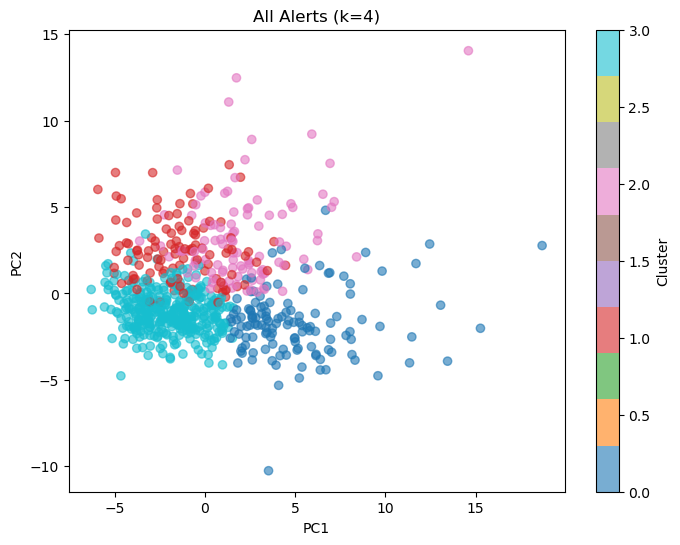

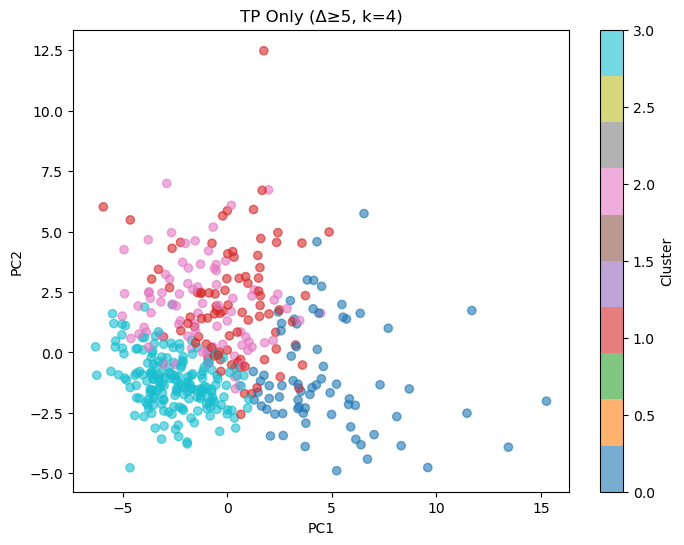

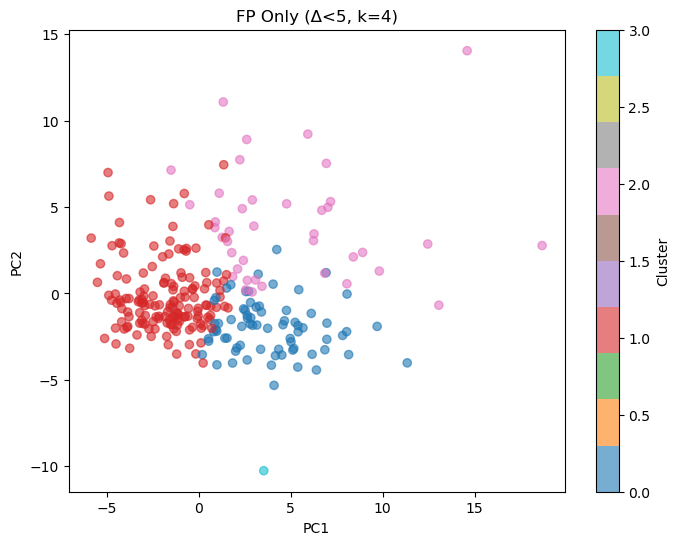

In [145]:
import matplotlib.pyplot as plt

def plot_clusters(df, cluster_col, title):
    plt.figure(figsize=(8,6))
    plt.scatter(df["PC1"], df["PC2"], c=df[cluster_col], cmap="tab10", alpha=0.6)
    plt.colorbar(label="Cluster")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.show()

# Visualize All / TP / FP clusters
plot_clusters(alerts_features, "cluster_all", "All Alerts (k=4)")
plot_clusters(alerts_features[tp_mask], "cluster_tp", "TP Only (Δ≥5, k=4)")
plot_clusters(alerts_features[fp_mask], "cluster_fp", "FP Only (Δ<5, k=4)")


# SHAP values

In [195]:
alerts_with_idx

,StudyID,ts,date,y_true_at_alert,y_prob_at_alert,success,success_120m,row_idx_x,row_idx_y,row_idx_y
0,1,2022-10-13 21:12:00,2022-10-13,1,0.512473,1,0,524,24,524
1,1,2022-10-14 11:42:00,2022-10-14,0,0.592443,0,0,582,82,582
2,1,2022-10-14 15:57:00,2022-10-14,1,0.465869,1,1,599,99,599
3,1,2022-10-14 20:42:00,2022-10-14,0,0.339081,0,0,618,118,618
4,1,2022-10-15 17:27:00,2022-10-15,1,0.521773,1,1,701,201,701
...,...,...,...,...,...,...,...,...,...,...
687,89,2023-05-08 13:23:00,2023-05-08,0,0.486642,0,0,69579,27710,69579
688,89,2023-05-08 16:53:00,2023-05-08,1,0.478899,1,1,69593,27724,69593
689,89,2023-05-08 21:08:00,2023-05-08,0,0.452270,0,0,69610,27741,69610
690,89,2023-05-09 11:23:00,2023-05-09,0,0.400450,0,1,69667,27798,69667


In [197]:
# Keep only row_idx_x and rename it to row_idx
alerts_with_idx = alerts_with_idx.rename(columns={"row_idx_x": "row_idx"})

# Drop the duplicated ones
alerts_with_idx = alerts_with_idx.drop(columns=["row_idx_y"], errors="ignore")

print(alerts_with_idx.head())
print(alerts_with_idx.columns)


   StudyID                  ts        date  y_true_at_alert  y_prob_at_alert  \
0        1 2022-10-13 21:12:00  2022-10-13                1         0.512473   
1        1 2022-10-14 11:42:00  2022-10-14                0         0.592443   
2        1 2022-10-14 15:57:00  2022-10-14                1         0.465869   
3        1 2022-10-14 20:42:00  2022-10-14                0         0.339081   
4        1 2022-10-15 17:27:00  2022-10-15                1         0.521773   

   success  success_120m  row_idx  
0        1             0      524  
1        0             0      582  
2        1             1      599  
3        0             0      618  
4        1             1      701  
Index(['StudyID', 'ts', 'date', 'y_true_at_alert', 'y_prob_at_alert',
       'success', 'success_120m', 'row_idx'],
      dtype='object')


In [209]:
from collections import Counter

# 1) 각 alert별 top-3 SHAP feature 뽑기
all_top_feats = []
for i in range(len(X_alerts)):
    vals = shap_values[i]
    abs_vals = np.abs(vals)
    top_idx = np.argsort(abs_vals)[-3:][::-1]  # 상위 3개 index
    top_feats = [X_columns[j] for j in top_idx]
    all_top_feats.extend(top_feats)  # 3개씩 append



# 2) 카운트
feat_counts = Counter(all_top_feats)

# 3) DataFrame으로 정리
feat_summary = pd.DataFrame(feat_counts.most_common(), columns=["Feature", "Count"])

# 4) 비율도 추가
feat_summary["Percent"] = feat_summary["Count"] / len(all_top_feats)

print("=== Top SHAP features across all alerts (flattened top3 per alert) ===")
print(feat_summary.head(15))


=== Top SHAP features across all alerts (flattened top3 per alert) ===
              Feature  Count   Percent
0           Intensity    588  0.283237
1              hungry    472  0.227360
2            Time_24h    295  0.142100
3   mean_intensity_1h    281  0.135356
4        Z_Previous_4     79  0.038054
5        How_stressed     62  0.029865
6           TimeInBed     59  0.028420
7      2_2.5h_pre_std     58  0.027938
8           How_tired     30  0.014451
9        15m_G_Diff_5     30  0.014451
10       15m_G_Diff_7     30  0.014451
11     1.5_2h_pre_std     22  0.010597
12        1h_pre_Thre     17  0.008189
13   G_minus_T_pre_2h     13  0.006262
14    2_2.5h_pre_mean     11  0.005299


In [215]:
import shap
import matplotlib.pyplot as plt

# 1) 마지막 fold 모델 (혹은 retrained RF 사용)
explainer = shap.TreeExplainer(model_fold)

# 2) 692 alerts에 해당하는 feature 추출
X_alerts = df_model.loc[alerts_with_idx["row_idx"], X_columns]

# 3) SHAP 값 계산 (class=1)
shap_values = explainer.shap_values(X_alerts)[1]  # positive class


# 6) 여러 alert 중 공통적으로 많이 나타난 Top 3 조합 카운트
top3_features_per_alert = np.argsort(-np.abs(shap_values), axis=1)[:, :3]
top3_feature_names = [[X_columns[i] for i in row] for row in top3_features_per_alert]

# Convert to string combinations
combos = [" + ".join(sorted(feats)) for feats in top3_feature_names]
combo_counts = pd.Series(combos).value_counts().head(10)

print("\n=== Most common Top-3 SHAP feature combinations ===")
print(combo_counts)



=== Most common Top-3 SHAP feature combinations ===
Intensity + Time_24h + hungry               128
Intensity + hungry + mean_intensity_1h       75
Intensity + Time_24h + mean_intensity_1h     74
2_2.5h_pre_std + Intensity + hungry          32
How_stressed + Intensity + hungry            31
15m_G_Diff_7 + Intensity + hungry            28
Intensity + Z_Previous_4 + hungry            27
15m_G_Diff_5 + Intensity + hungry            27
Time_24h + hungry + mean_intensity_1h        20
Intensity + TimeInBed + hungry               17
Name: count, dtype: int64


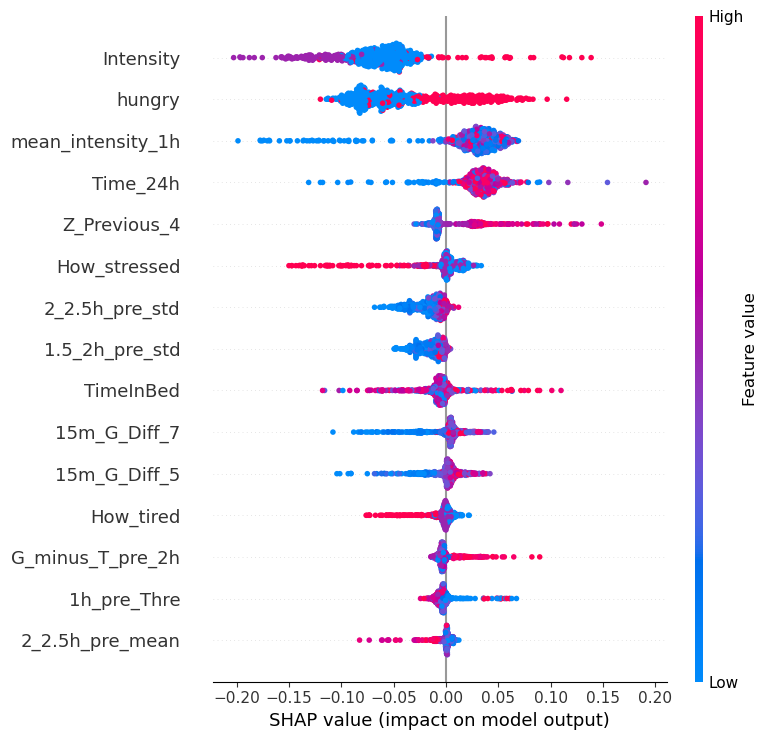

In [225]:
import shap
import matplotlib.pyplot as plt

# 전체 SHAP에서 필요한 feature 인덱스만 추출
feat_idx = [X_columns.index(f) for f in top_feats]
shap_values_sub = shap_values[:, feat_idx]
X_sub = X_alerts[top_feats].fillna(0)

shap.summary_plot(shap_values_sub, X_sub, feature_names=top_feats, plot_type="dot")



Combo ['Intensity', 'Time_24h', 'hungry'] found in 128 alerts


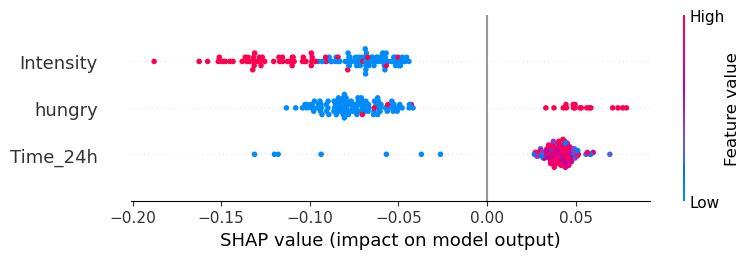

In [247]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# === 1) 조합 정의 ===
combo = ["Intensity", "Time_24h", "hungry"]

# === 2) 각 alert의 top3 feature 인덱스 추출 ===
top3_per_alert = np.argsort(-np.abs(shap_values), axis=1)[:, :3]
top3_feats = np.array(X_alerts.columns)[top3_per_alert]

# === 3) combo 포함 row 찾기 ===
mask_combo = [set(combo).issubset(set(row)) for row in top3_feats]
alerts_combo_idx = np.where(mask_combo)[0]
print(f"Combo {combo} found in {len(alerts_combo_idx)} alerts")

# === 4) subset 데이터 준비 (hungry는 숫자형 유지) ===
X_sub = X_alerts.iloc[alerts_combo_idx][combo].fillna(0)
shap_sub = shap_values[alerts_combo_idx][:, [X_columns.index(f) for f in combo]]

# === 5) SHAP summary plot ===
shap.summary_plot(
    shap_sub,
    X_sub,
    feature_names=combo,
    plot_type="dot"
)
plt.show()


Combo ['Intensity', 'hungry', 'mean_intensity_1h'] found in 75 alerts


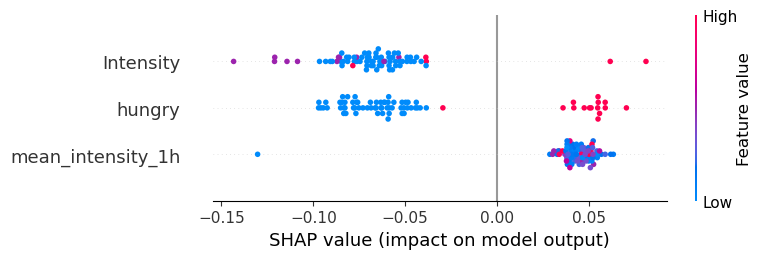

In [249]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# === 1) 조합 정의 ===
combo = ["Intensity", "hungry", "mean_intensity_1h"]

# === 2) 각 alert의 top3 feature 인덱스 추출 ===
top3_per_alert = np.argsort(-np.abs(shap_values), axis=1)[:, :3]
top3_feats = np.array(X_alerts.columns)[top3_per_alert]

# === 3) combo 포함 row 찾기 ===
mask_combo = [set(combo).issubset(set(row)) for row in top3_feats]
alerts_combo_idx = np.where(mask_combo)[0]
print(f"Combo {combo} found in {len(alerts_combo_idx)} alerts")

# === 4) subset 데이터 준비 (hungry는 숫자형 유지) ===
X_sub = X_alerts.iloc[alerts_combo_idx][combo].fillna(0)
shap_sub = shap_values[alerts_combo_idx][:, [X_columns.index(f) for f in combo]]

# === 5) SHAP summary plot ===
shap.summary_plot(
    shap_sub,
    X_sub,
    feature_names=combo,
    plot_type="dot"
)
plt.show()


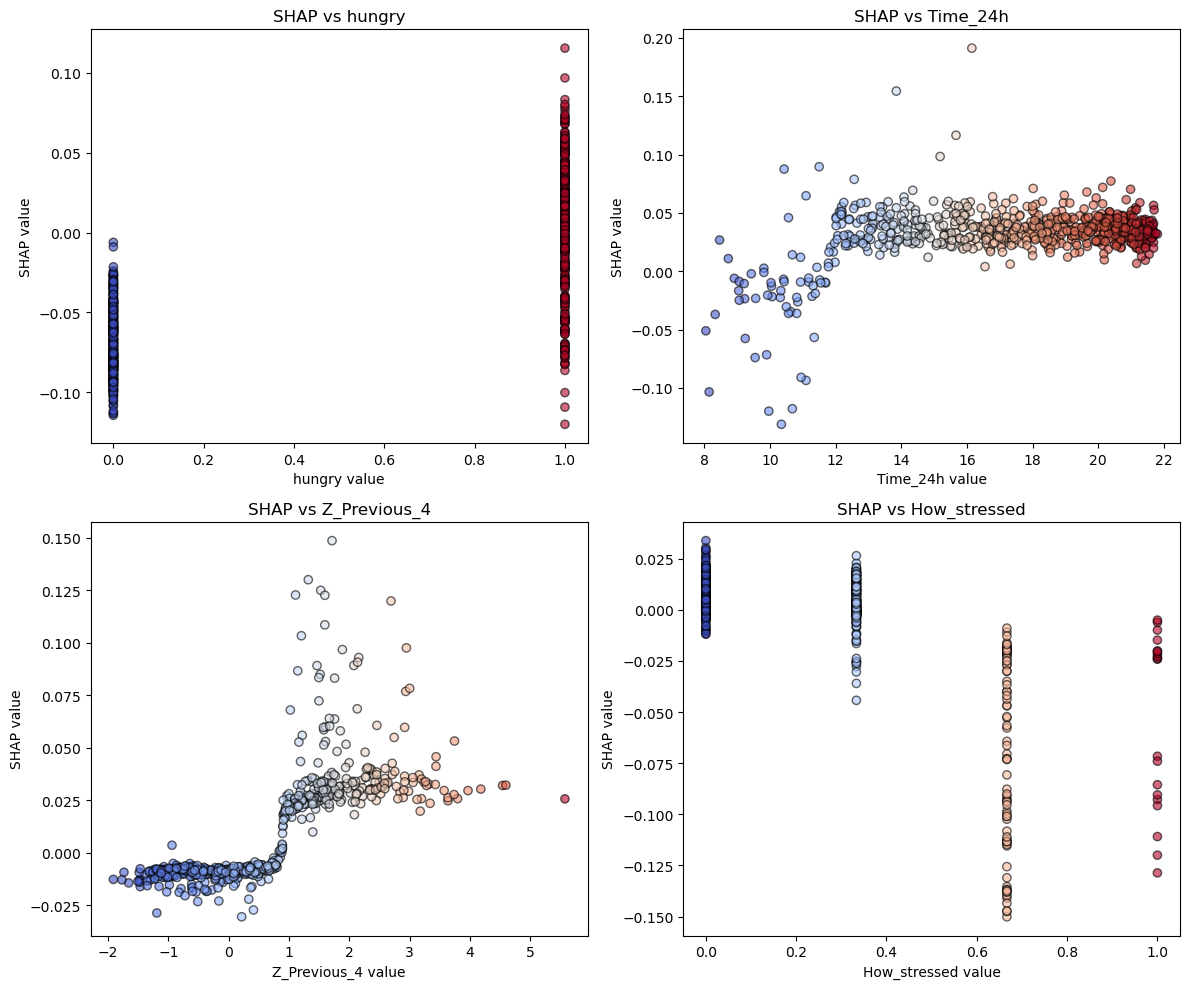

In [251]:
import matplotlib.pyplot as plt

# 관심 feature
features_to_plot = ["hungry", "Time_24h", "Z_Previous_4", "How_stressed"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feat in enumerate(features_to_plot):
    feat_idx = X_columns.index(feat)
    
    plt.sca(axes[i])
    plt.scatter(
        X_alerts[feat], 
        shap_values[:, feat_idx], 
        c=X_alerts[feat], 
        cmap="coolwarm", 
        alpha=0.6, 
        edgecolor="k"
    )
    plt.xlabel(f"{feat} value")
    plt.ylabel("SHAP value")
    plt.title(f"SHAP vs {feat}")

plt.tight_layout()
plt.show()
